In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder , OneHotEncoder , StandardScaler

from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score , f1_score , precision_score , recall_score , roc_curve , roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import RandomizedSearchCV

In [2]:
df = pd.read_csv('Data/cleaned_Travel.csv')

df.head()

,ProdTaken,Age,TypeofContact,CityTier,DurationOfPitch,Occupation,Gender,NumberOfFollowups,ProductPitched,PreferredPropertyStar,MaritalStatus,NumberOfTrips,Passport,PitchSatisfactionScore,OwnCar,Designation,MonthlyIncome,TotalPersonVisting
0,1,41,Self Enquiry,3,6,Salaried,Female,3,Deluxe,3,Unmarried,1,1,2,1,Manager,20993,3
1,0,49,Company Invited,1,14,Salaried,Male,4,Deluxe,4,Divorced,2,0,3,1,Manager,20130,5
2,1,37,Self Enquiry,1,8,Free Lancer,Male,4,Basic,3,Unmarried,7,1,3,0,Executive,17090,3
3,0,33,Company Invited,1,9,Salaried,Female,3,Basic,3,Divorced,2,1,5,1,Executive,17909,3
4,0,36,Self Enquiry,1,8,Small Business,Male,3,Basic,4,Divorced,1,0,5,1,Executive,18468,2


TRAIN TEST SPLIT

In [3]:
X = df.drop('ProdTaken', axis=1)

y = df['ProdTaken']

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3666, 17), (1222, 17), (3666,), (1222,))

In [5]:
cat_col = X.select_dtypes(include = 'object').columns

num_col = X.select_dtypes(exclude = ['object']).columns

numeric_transformer = StandardScaler()

categorical_transformer = OneHotEncoder(drop = 'first')

preprocessor = ColumnTransformer(
    transformers = [
        ('OneHotEncoder', categorical_transformer, cat_col) , 
        ('standardScaler' , numeric_transformer, num_col)
    ], remainder='passthrough'
)
preprocessor

X_train = preprocessor.fit_transform(X_train)

X_test = preprocessor.transform(X_test)




In [6]:
pd.DataFrame(X_train).head()

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.721708,-0.667550,0.277912,1.777611,2.159941,1.575272,0.681958,-1.273702,-0.415942,-0.058810
1,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,-0.721708,-0.165964,-0.723883,-0.724971,-0.694545,-0.634811,1.409353,0.785113,-0.224146,-0.768009
2,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,-0.721708,-0.291361,1.279708,0.526320,1.589044,-0.634811,0.681958,0.785113,-0.711215,-0.768009
3,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,1.454995,-0.542154,0.277912,1.777611,-0.694545,-0.634811,1.409353,0.785113,0.057482,-0.058810
4,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,-0.721708,0.335622,-0.723883,-0.724971,-0.694545,1.575272,0.681958,0.785113,-1.139911,-0.058810


In [7]:
# Define the models

models = {
    'XGBClassifier': XGBClassifier(),
    'GradientBoostingClassifier': GradientBoostingClassifier(),
    'RandomForestClassifier': RandomForestClassifier()
}

for name , clf in models.items() :

    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)

    print(f"Model {name} trained successfully.")
    print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
    print(f"F1 Score: {f1_score(y_test, y_pred)}")
    print(f"Precision: {precision_score(y_test, y_pred)}")
    print(f"Recall: {recall_score(y_test, y_pred)}")
    print(f"ROC AUC: {roc_auc_score(y_test, y_pred)}")

    print("\n" + "="*50 + "\n")
    

Model XGBClassifier trained successfully.
Accuracy: 0.9410801963993454
F1 Score: 0.8208955223880597
Precision: 0.9217877094972067
Recall: 0.7399103139013453
ROC AUC: 0.8629481499436656


Model GradientBoostingClassifier trained successfully.
Accuracy: 0.8723404255319149
F1 Score: 0.5411764705882353
Precision: 0.7863247863247863
Recall: 0.4125560538116592
ROC AUC: 0.6937655143933171


Model RandomForestClassifier trained successfully.
Accuracy: 0.9271685761047463
F1 Score: 0.7588075880758808
Precision: 0.958904109589041
Recall: 0.6278026905829597
ROC AUC: 0.8108983422884769




HYPERPARAMTER TUNING THE XGBOOST MODEL

In [8]:
param_grid = {
    
    'n_estimators': [50, 100, 200],

    'max_depth': [3, 5, 7],

    'learning_rate': [0.1 , 0.5 , 1],

    'subsample': [0.8, 0.9, 1.0],

    'colsample_bytree': [0.8 , 1.0]
}

random_search = RandomizedSearchCV(models['XGBClassifier'], param_distributions=param_grid , cv = 5 , n_iter = 100)

random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           max_delta_step=None, max_depth=None,
                                           max_leaves=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=None, ...),
                   n_iter=100,
                   param_distributions={'colsample_bytree': [0.8, 1.0],
                                        'learning_rate': [0.1, 0.5, 1],
                                        'max_depth': [3, 5, 7],
                                        'n_estimators': [50, 100, 200],
                                        'subsample': [0.8, 0.9, 1.0]})

In [9]:
print("Best parameters found: ", random_search.best_params_)

Best parameters found:  {'subsample': 0.9, 'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.5, 'colsample_bytree': 1.0}


In [10]:
y_pred_best = random_search.predict(X_test)

print(f"Best Model Accuracy: {accuracy_score(y_test, y_pred_best)}")
print(f"Best Model F1 Score: {f1_score(y_test, y_pred_best)}")
print(f"Best Model Precision: {precision_score(y_test, y_pred_best)}")
print(f"Best Model Recall: {recall_score(y_test, y_pred_best)}")
print(f"Best Model ROC AUC: {roc_auc_score(y_test, y_pred_best)}")

Best Model Accuracy: 0.9468085106382979
Best Model F1 Score: 0.8402948402948403
Best Model Precision: 0.9293478260869565
Best Model Recall: 0.7668161434977578
Best Model ROC AUC: 0.8769015652423724


In [ ]:
y_prob = random_search.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_prob)

roc_auc = auc(fpr, tpr)

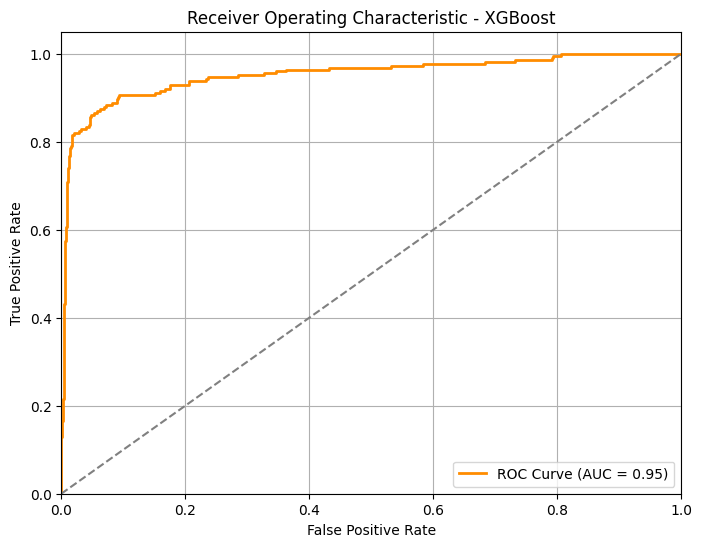

In [17]:
# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - XGBoost')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [11]:
import pickle

# Save the best model
with open('best_model.pkl', 'wb') as f:
    pickle.dump(random_search.best_estimator_, f)

# Save the preprocessor
with open('preprocessor.pkl', 'wb') as f:
    pickle.dump(preprocessor, f)